# Рекомендательная система для телеком компании (рекомендация тарифов)

## Описание проекта

**Заказчик**: федеральный оператор сотовой связи "Мегалайн".

**Данные**: данные 500 пользователей за 2018 год по использованию двух тарифных планов: «Смарт» и «Ультра».

**Описание данных**:

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

    сalls — количество звонков  
    minutes — суммарная длительность звонков в минутах  
    messages — количество sms-сообщений
    mb_used — израсходованный интернет-трафик в Мб
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)
    
**Особенность данных**: значения минут и мегабайтов округлены вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Бизнес-цель**: рекомендация тарифа для пользователя.

**Задача**: построить модель для задачи классификации по рекомендации тарифа.

**Метрика**: accuracy >=0.75 на отложенной выборке.

## Анализ общей информации

In [1]:
# Для анализа данных будем использовать библиотеку sweetviz 
!pip install sweetviz -q
!pip install catboost -q

Библиотека sweetviz поможет в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данная библиотека выбрана для максимизации комфорта презентации результатов анализа бизнес-пользователям.

In [2]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные
import sweetviz as sv 
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

# для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Игнорирование предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

SEED = 42

Считываем данные

In [3]:
# Прочитаем данные и запишем в переменную df
name = 'users_behavior.csv'

try: 
    df = pd.read_csv('datasets\\{}'.format(name))
except:
    print(print('Файл {} не найден и будет скачиваться по сети.'.format(name)))
    df = pd.read_csv('https://code.s3.yandex.net/datasets/{}'.format(name))    

Файл users_behavior.csv не найден и будет скачиваться по сети.
None



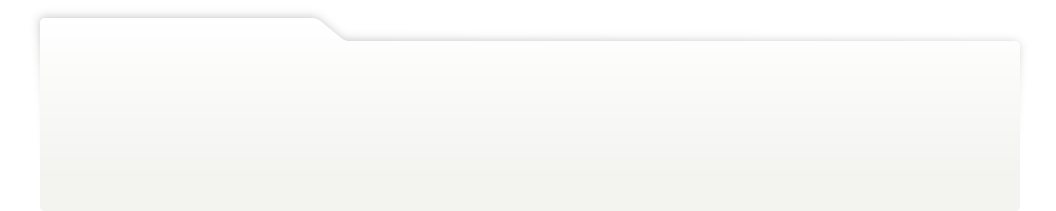
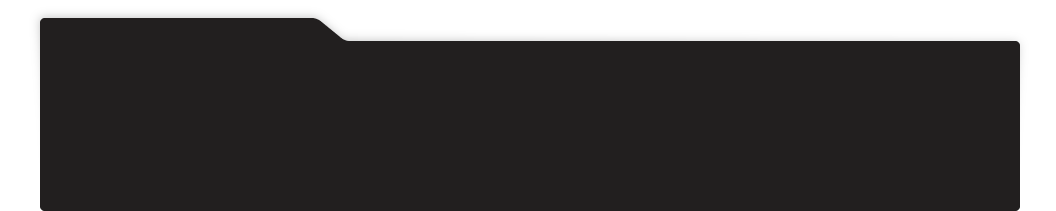
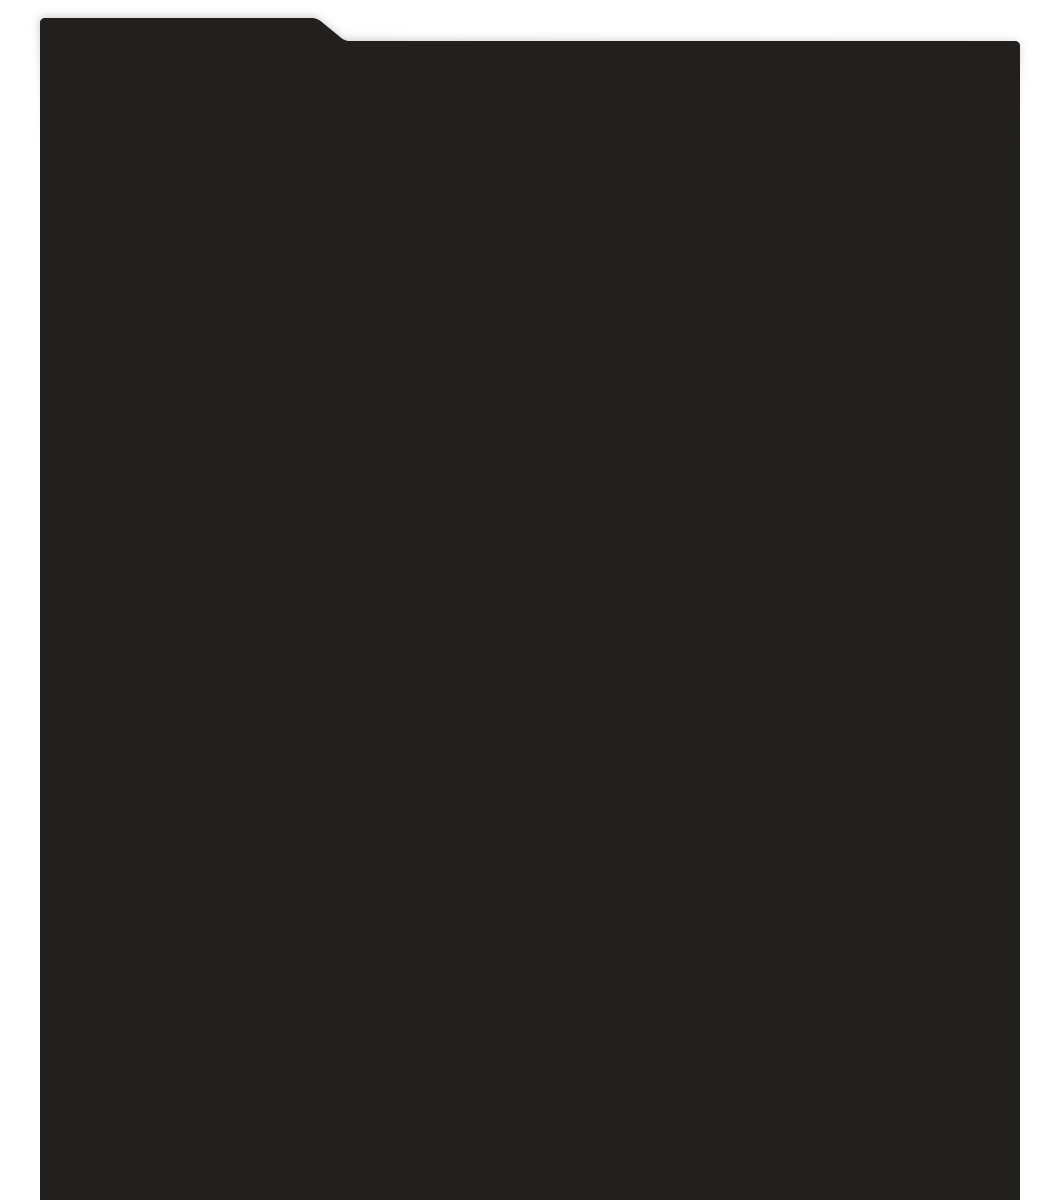
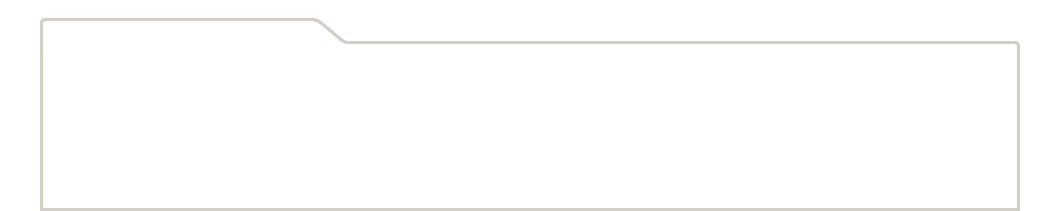
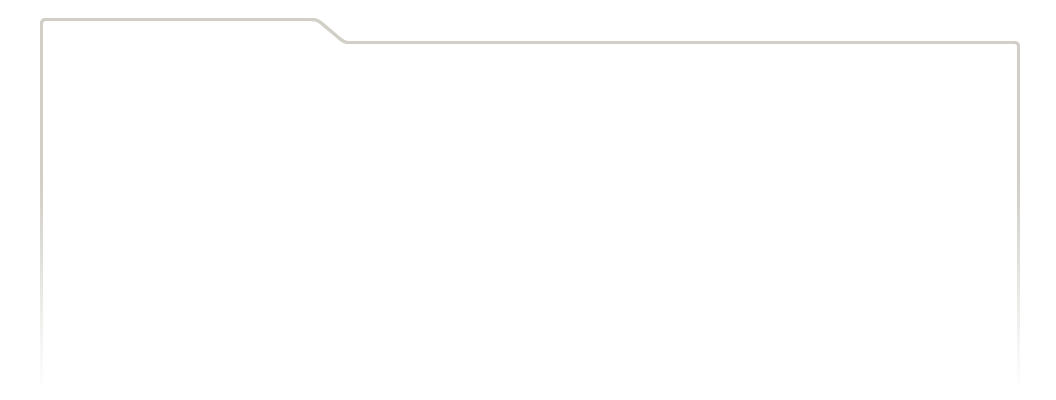
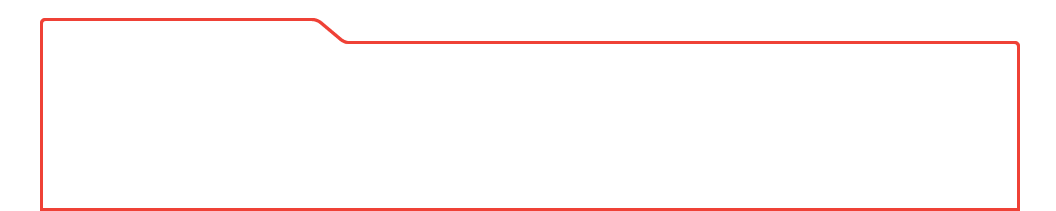
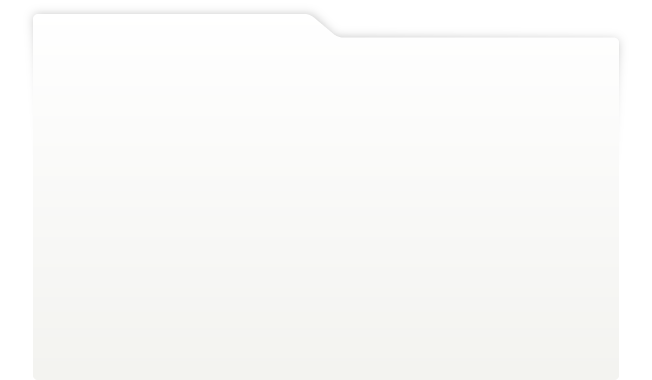
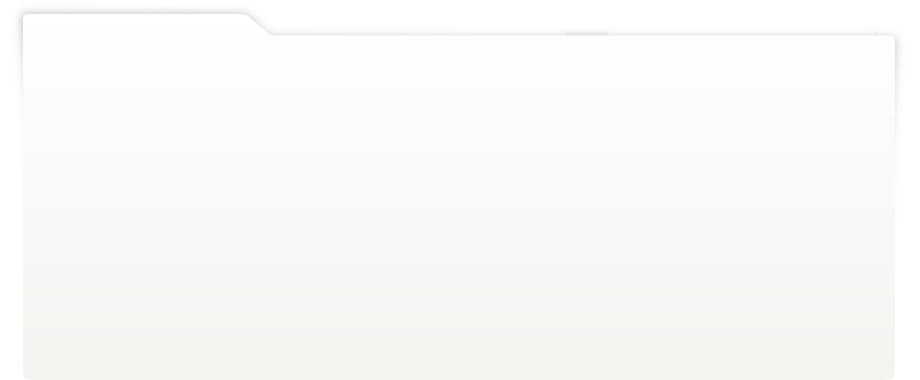
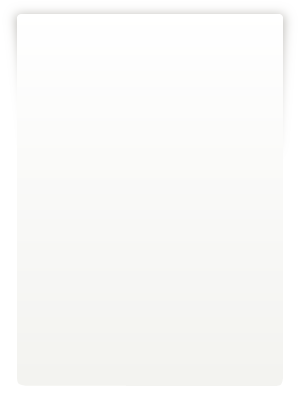
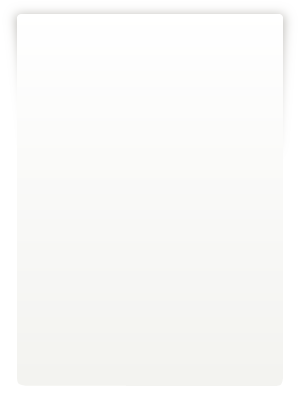
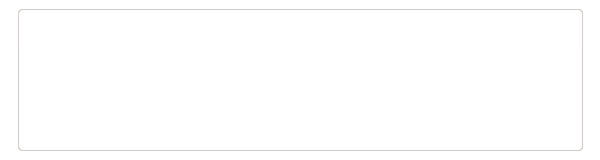
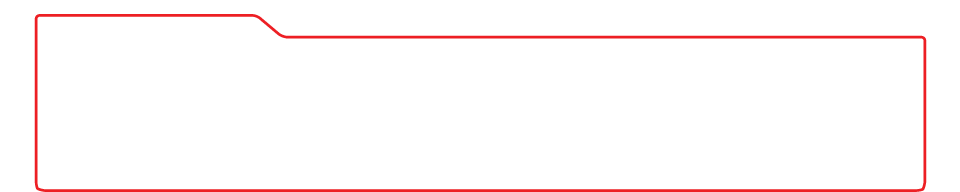
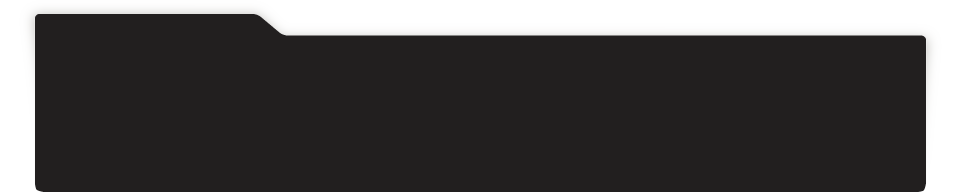
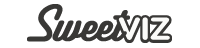
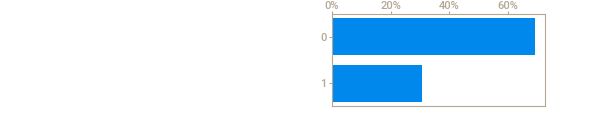
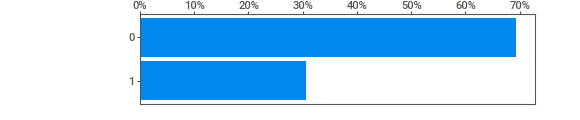
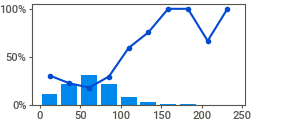
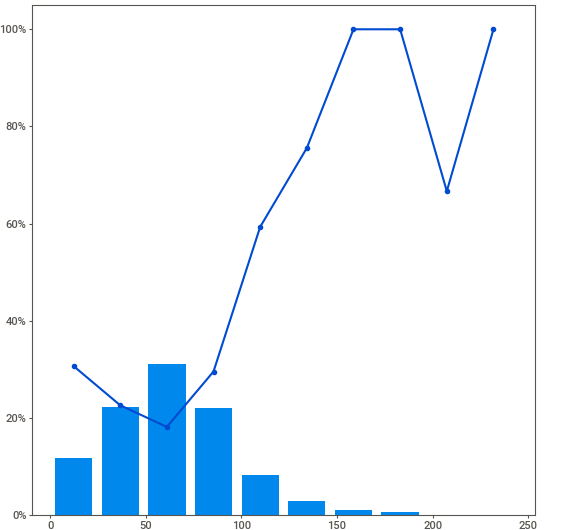
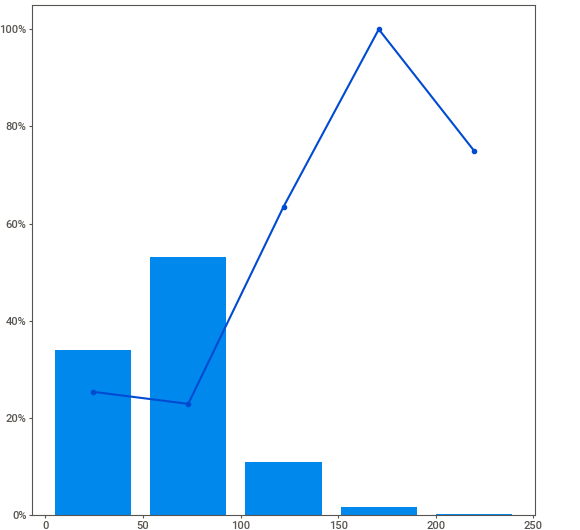
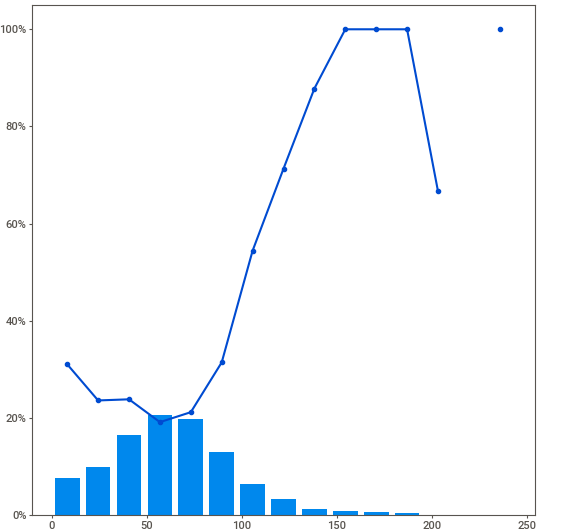
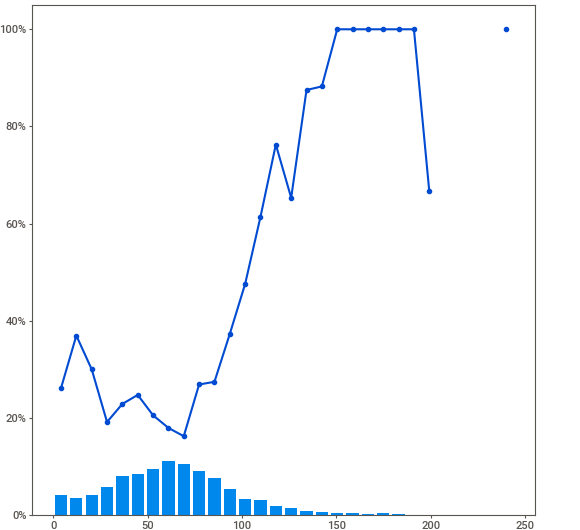
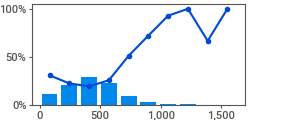
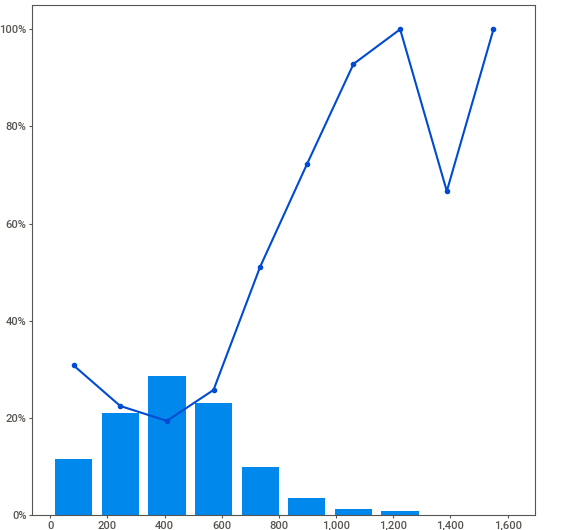
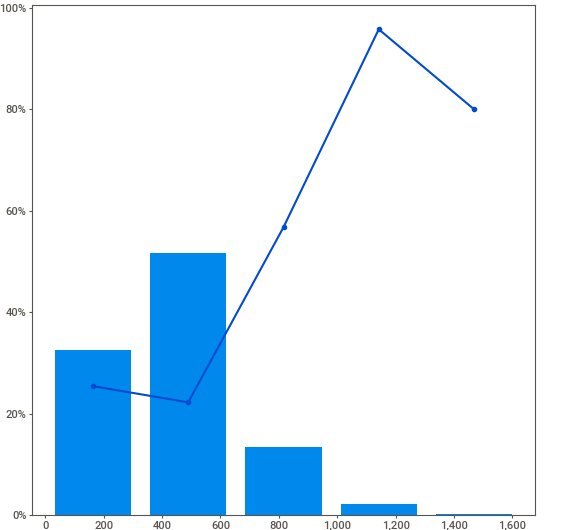
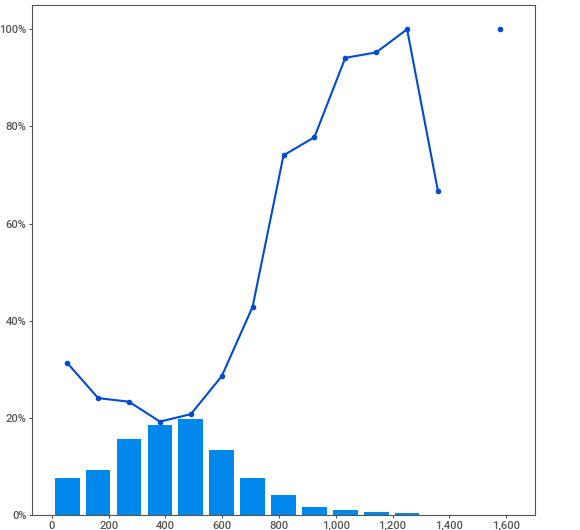
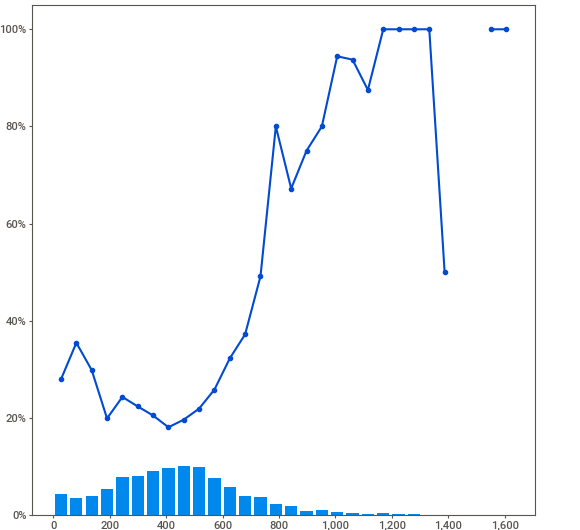
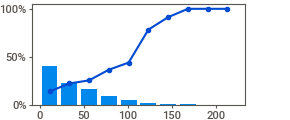
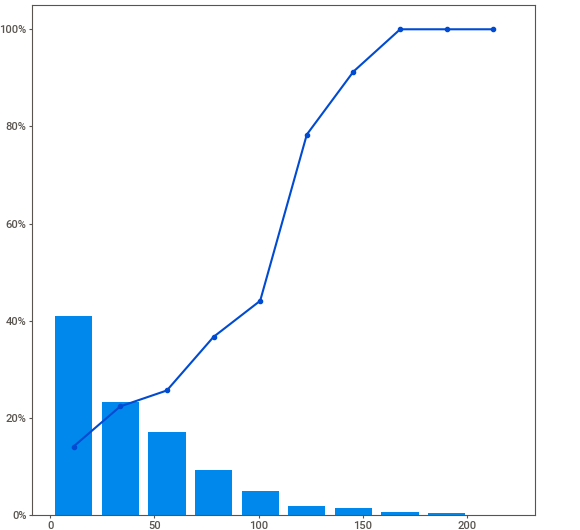
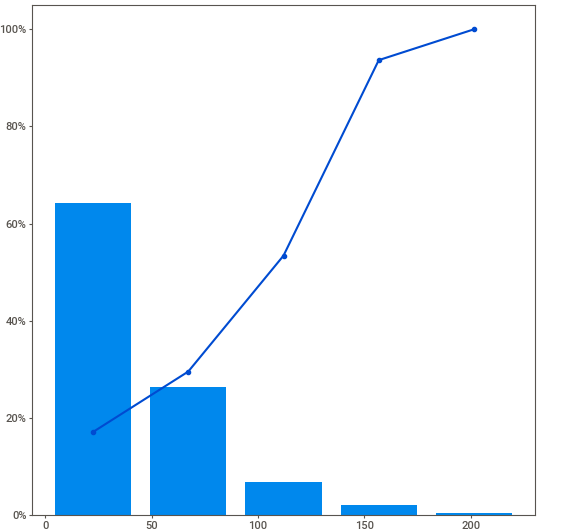
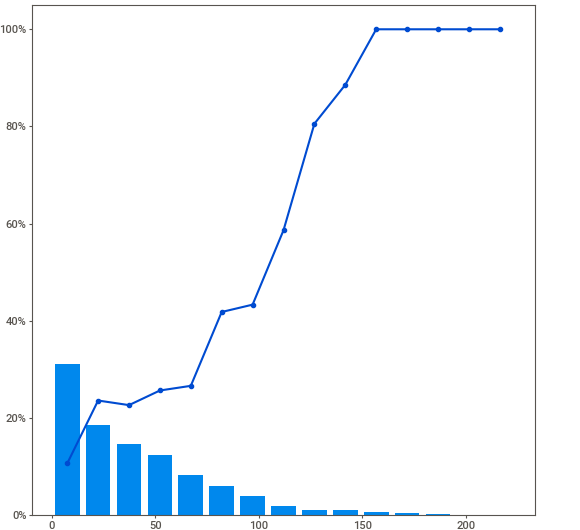
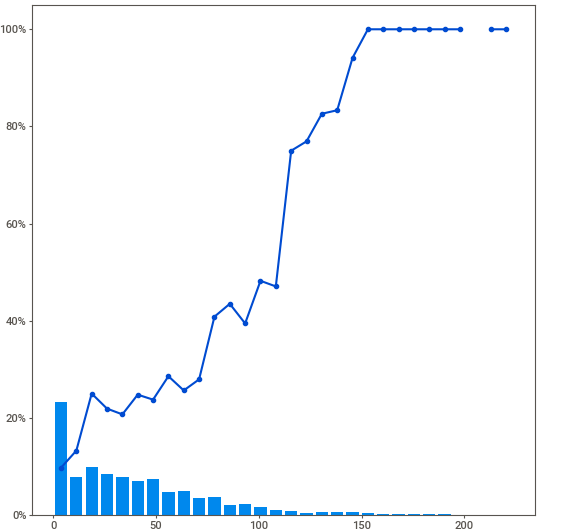
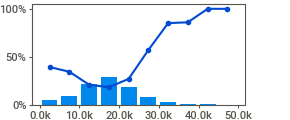
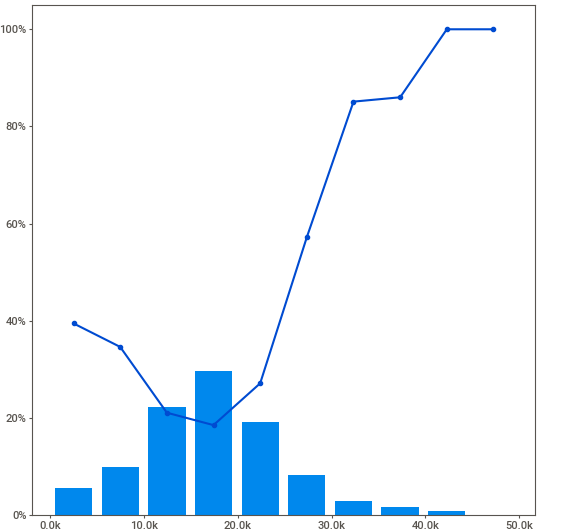
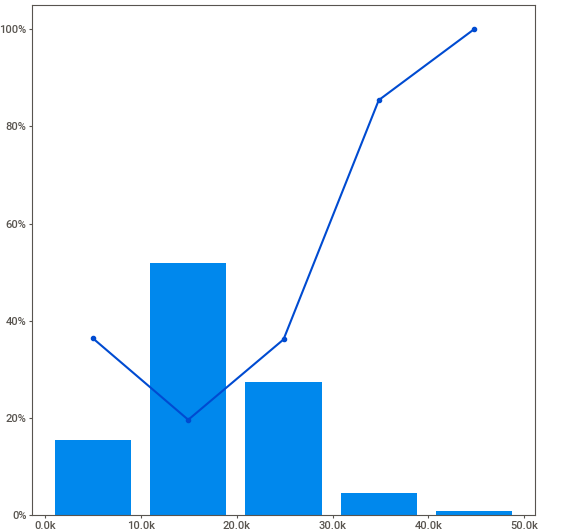
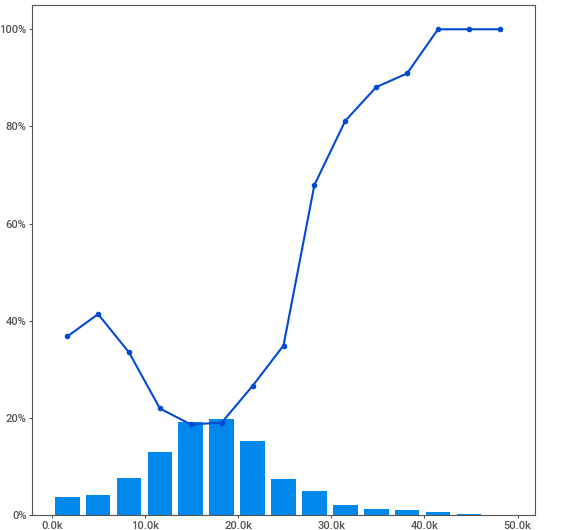
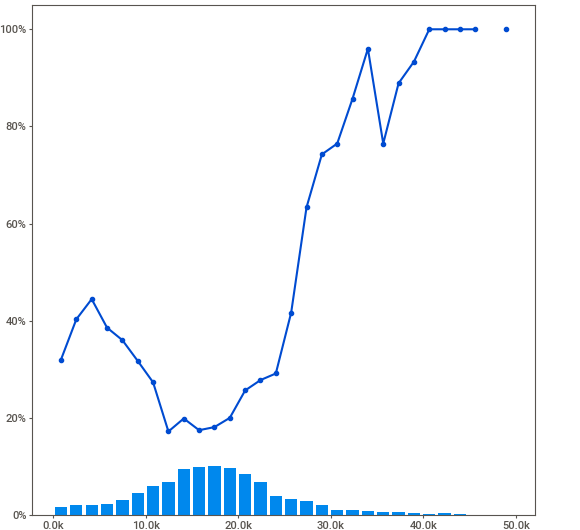
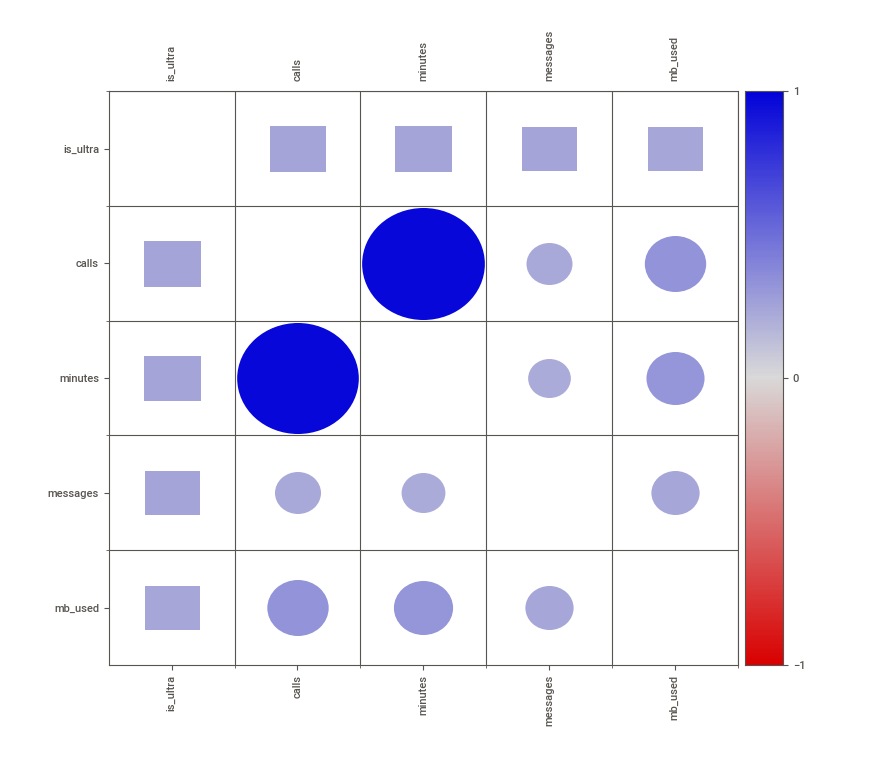
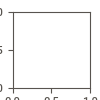

In [4]:
sv_report = sv.analyze(df, target_feat = 'is_ultra')
sv_report.show_notebook() 

Инструмент sweetviz по своей функциональности похож на известный многим pandas_profiling и тоже используется для EDA анализа. Отличительной особенностью является возможность добавить целевой признак и визуализации с разделением набора данных на обучающий и тестовый наборы данных (будет продемонстрировано ниже).

Проанализировав предоставленные отчеты по признакам можно сделать акцент на следующем:

- между признаками `minutes` и `calls` имеется высокая положительная корреляция (0.98). Требуется более внимательно изучить вопрос мультиколлинеарности в рассматриваемом наборе данных.
- выборка несбаллансирована - значений одного из прогнозируемых классов значительно больше. Требуется более детально проверить долевое распределение.  
- в признаках `minutes` и `calls` имеется спад пользовательского интереса примерно на 40% при количстве звонков 200 и минут 1400. Для анализа данного фактора требуется больше данных, требуется дополнительный анализ.
- заметна тенденция и определенные пороги по показателям количества звонков (60), минут (400), сообщений (100), использованных Мб (18000) - увеличение доли пользователей тарифа "Ультра" при значениях больше пороговых.

Проверим корреляцию между признаками и построим график типа scatterplot

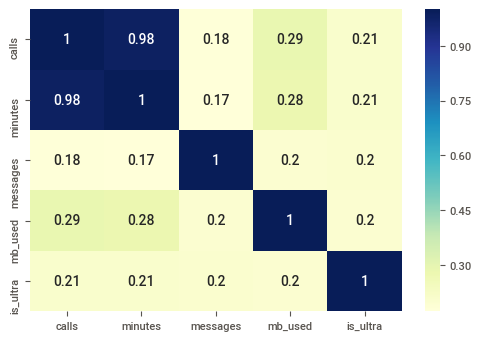

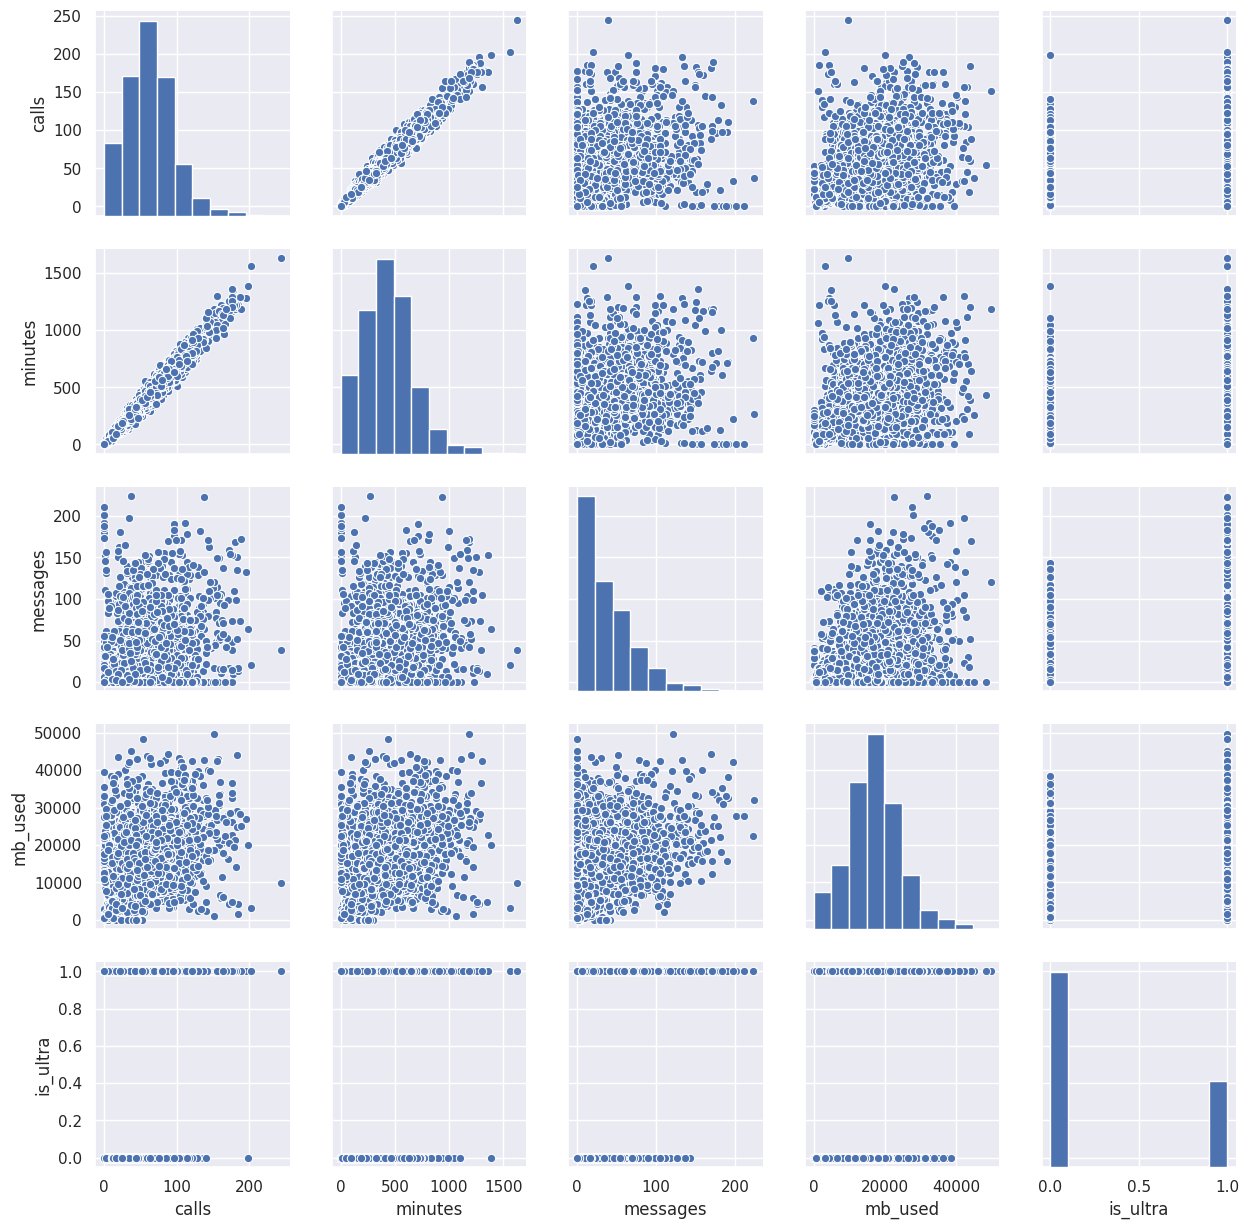

In [5]:
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

sns.set() 
sns.pairplot(df, size = 2.5)
plt.show();

Посмотрим на распределение данных по нашей целевой переменной — is_ultra

In [6]:
df['is_ultra'].value_counts()

# посмотрим распределение классов в долях
print('Класс Smart {:.0%}'.format(1-df['is_ultra'].mean()))
print('Класс Ultra {:.0%}'.format(df['is_ultra'].mean()))

0    2229
1     985
Name: is_ultra, dtype: int64

Класс Smart 69%
Класс Ultra 31%


**Вывод**

В результате анализа выявлено: 
- преобразование типов не требуется 
- пропуски отсутствуют 
- диапозоны значений соответствуют логике данных
- высокая положительная корреляция (0.98) между признаками `mintes` и `calls`. Данная особеность может негативно отразиться на качестве работы моделей машинного обучения, т.к. модель будет уделять данным признакам гораздо больше внимания чем остальным. Требуется удалить один из коррелирующих признаков, например calls, т.к. тариф в большей степени характеризуется количеством использованных минут, а не количеством звонков.
- дисбаланс классов в целевой переменной

## Предобработка данных

Выделим из набора данных целевой признак в отдельный набор и попутно удалим признак `calls` из основного набора

In [7]:
features = df.drop(['calls'], axis=1)
target = df['is_ultra']

Разделим получившиеся наборы на обучающую и тестовую выборки в соотношени 80/20. Будем использовать паремтр stratify для задания пропорции классов при разделении.

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target)

Проверим размеры получившихся выборок

In [9]:
for name, data in {'features_train': features_train, 
                   'features_test': features_test,
                   'target_train': target_train, 
                   'target_test': target_test}.items():
    print("Размер выборки %s:"  % (name),(data.shape))

Размер выборки features_train: (2571, 4)
Размер выборки features_test: (643, 4)
Размер выборки target_train: (2571,)
Размер выборки target_test: (643,)


Повторно запустим инструмент sweetviz для анализа схожести распределения признаков и целевого признака.


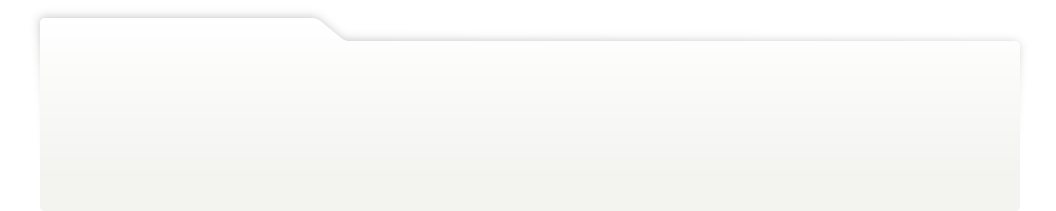
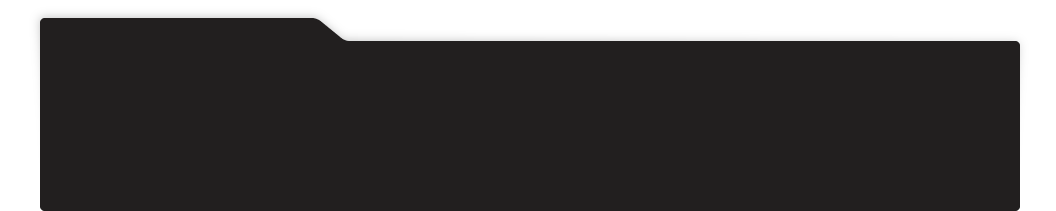
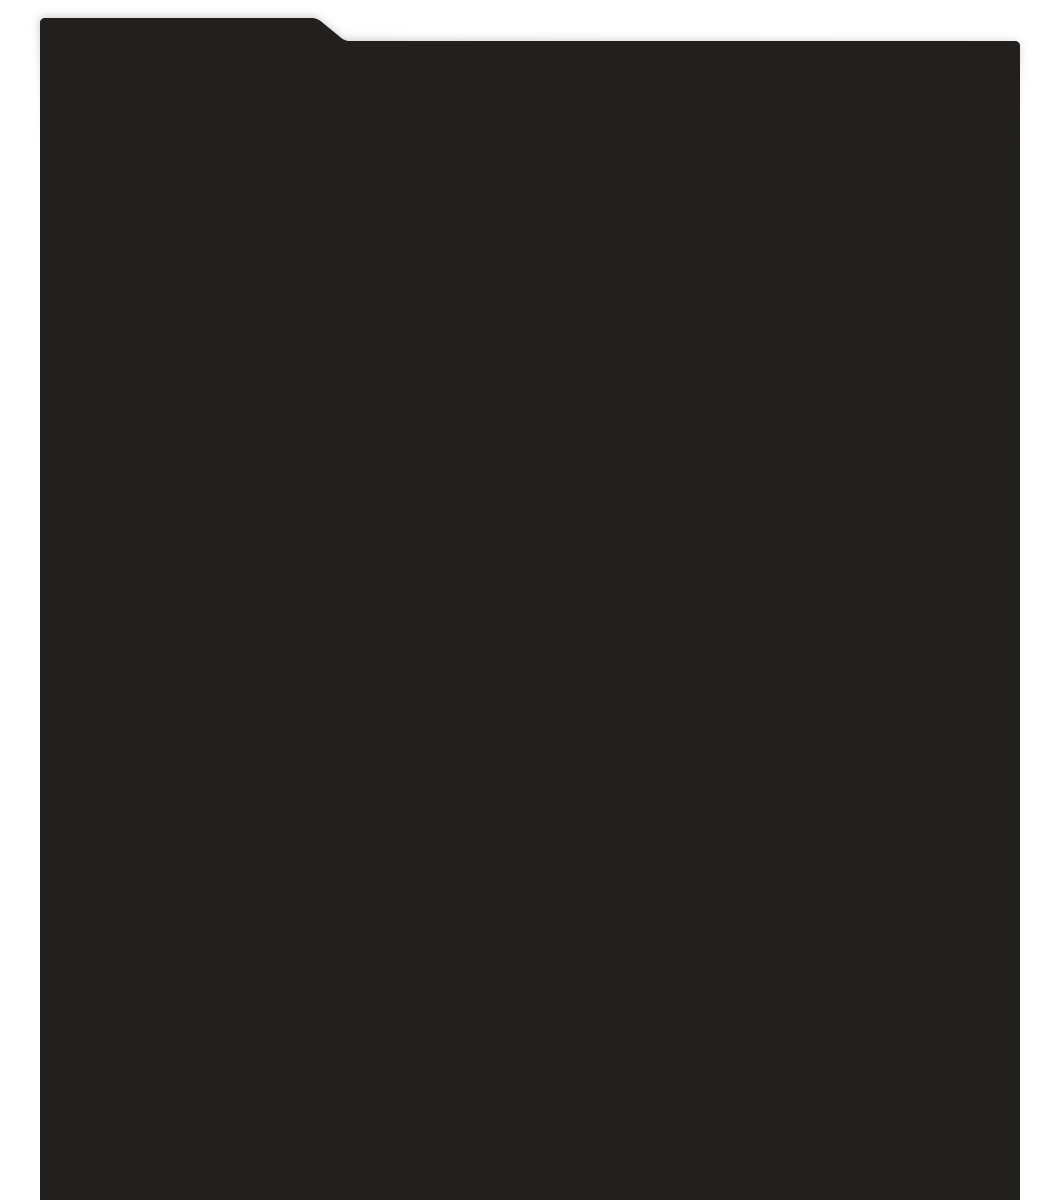
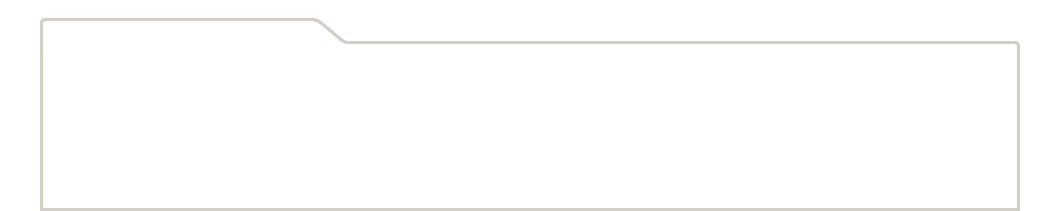
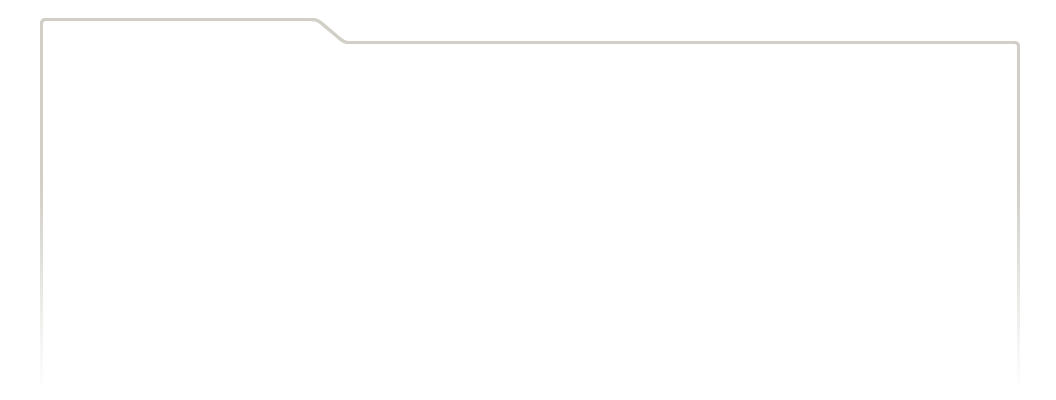
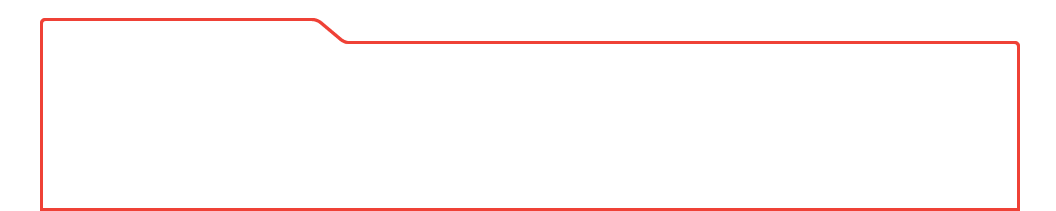
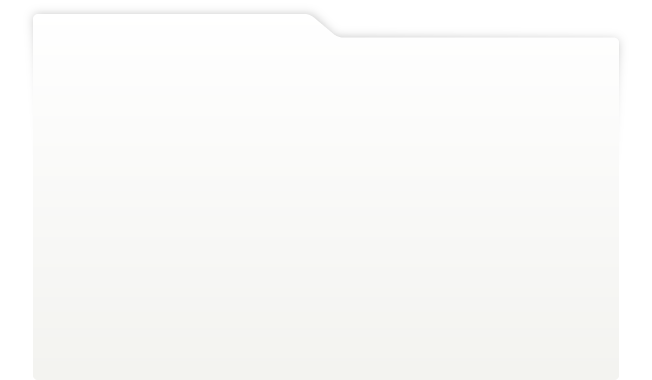
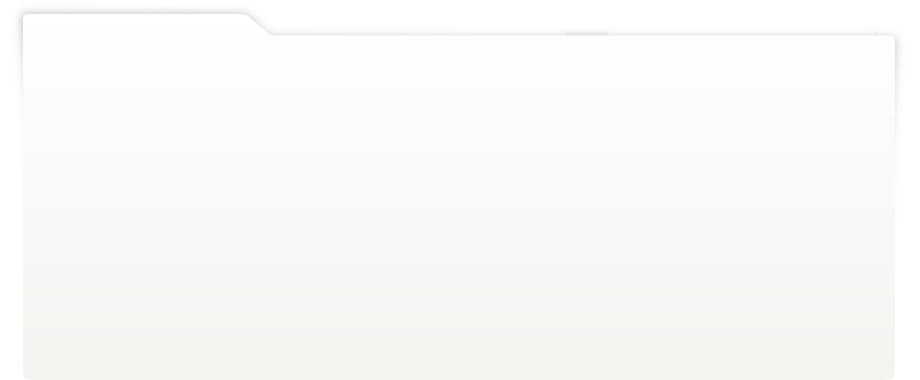
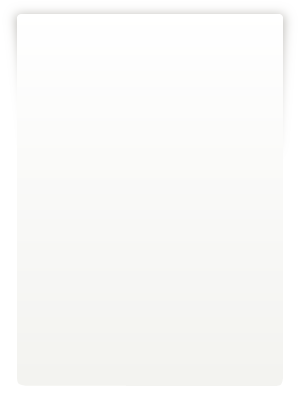
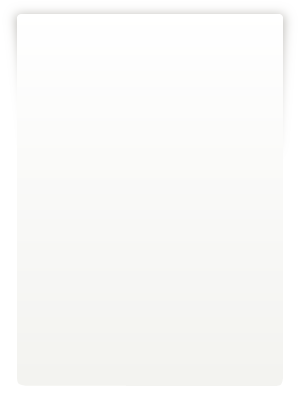
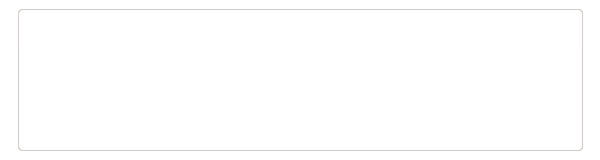
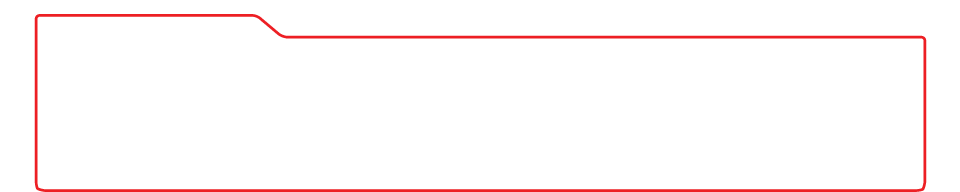
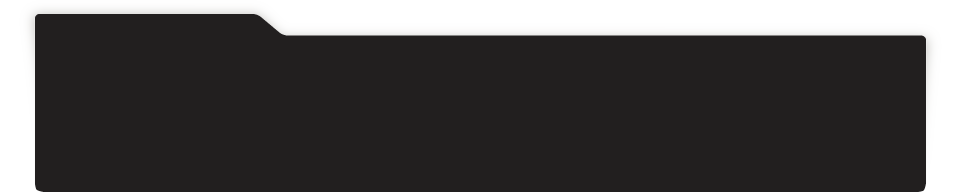
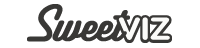
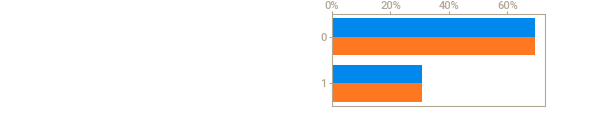
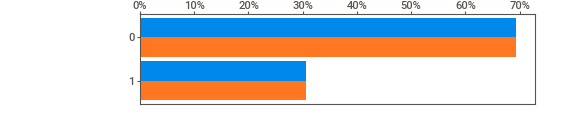
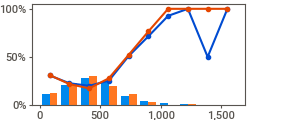
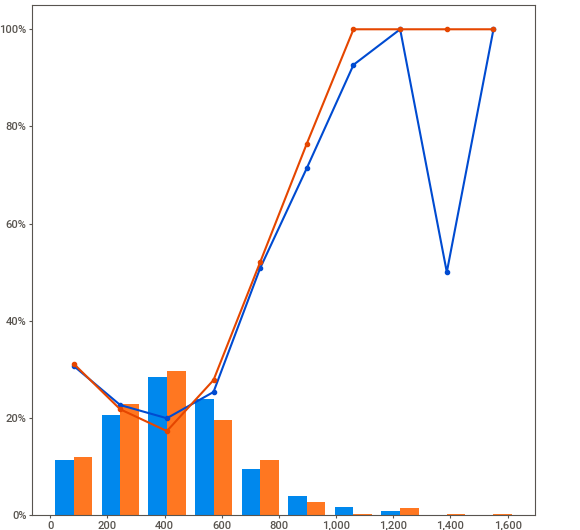
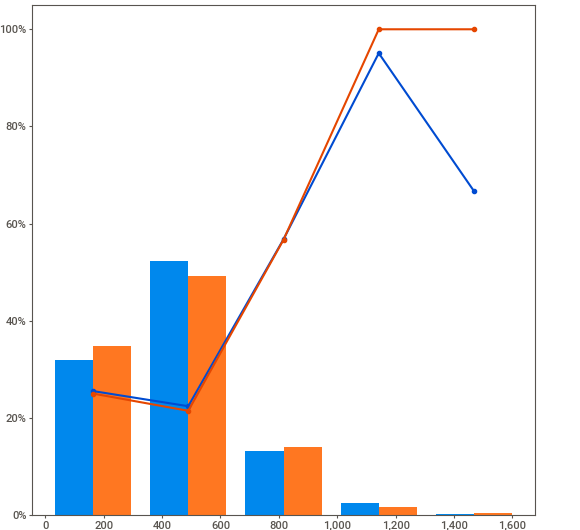
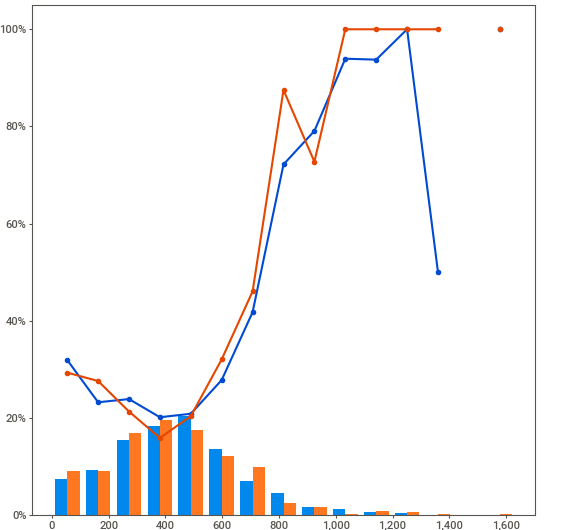
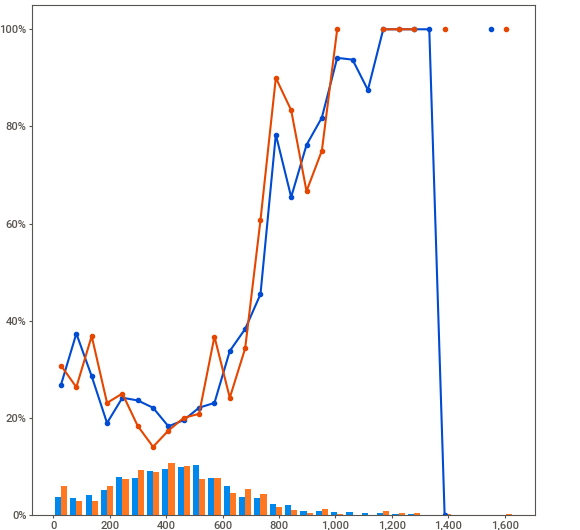
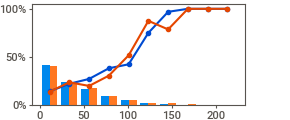
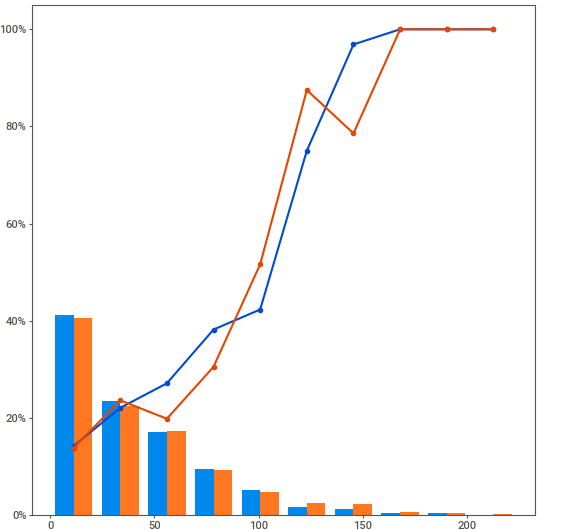
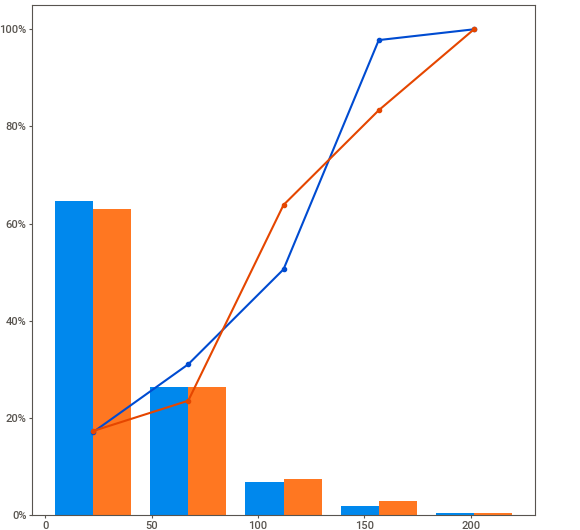
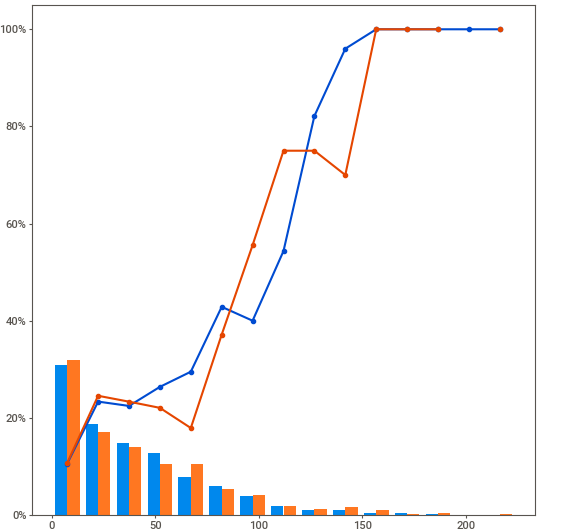
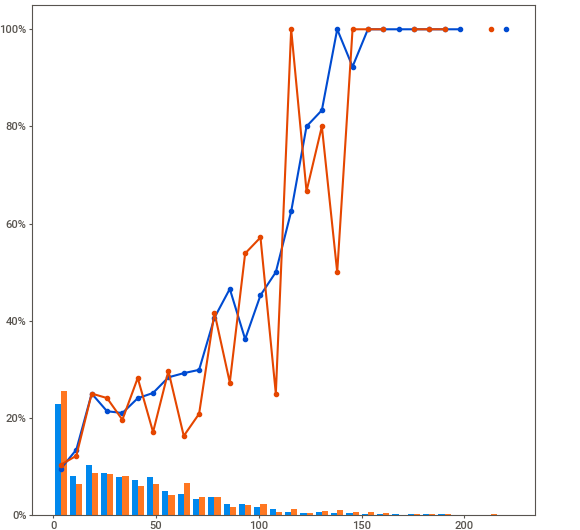
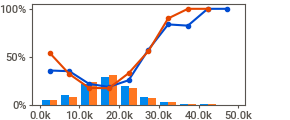
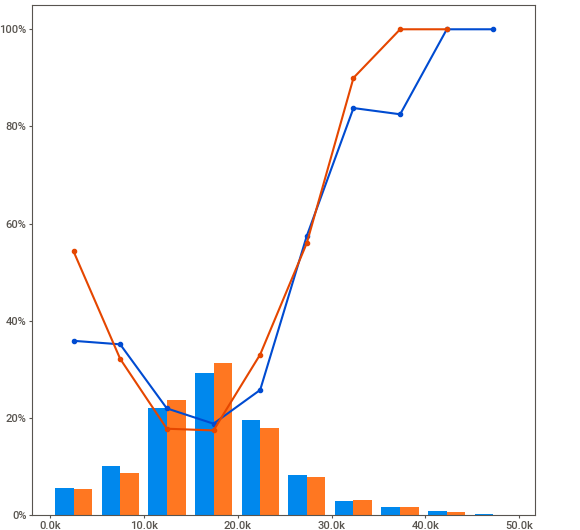
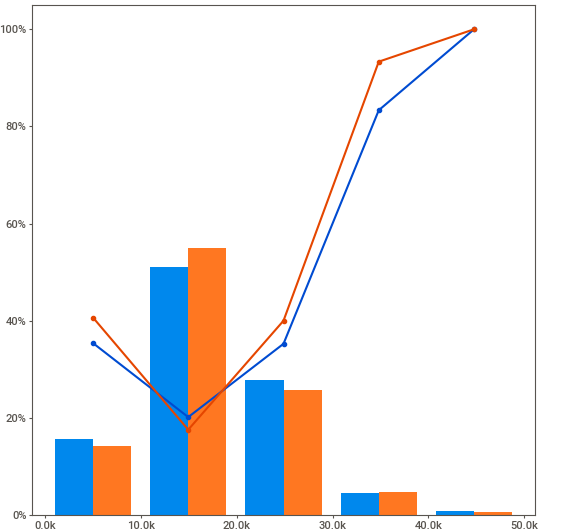
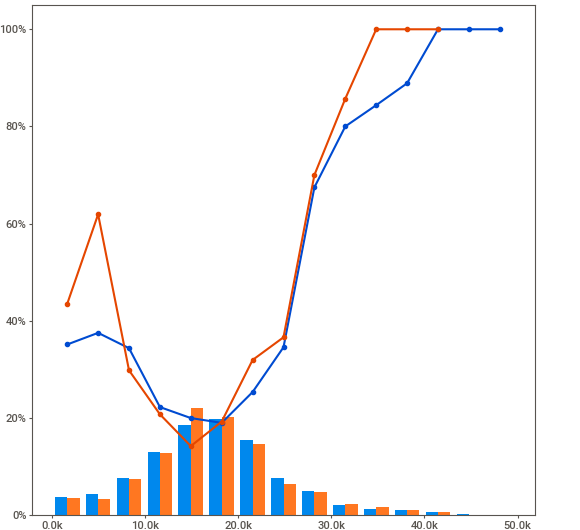
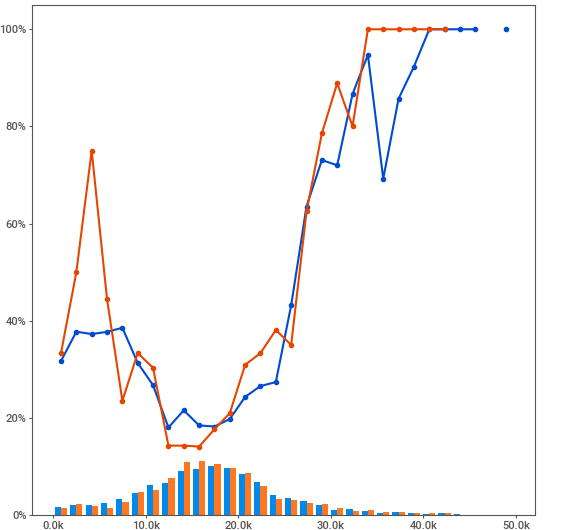
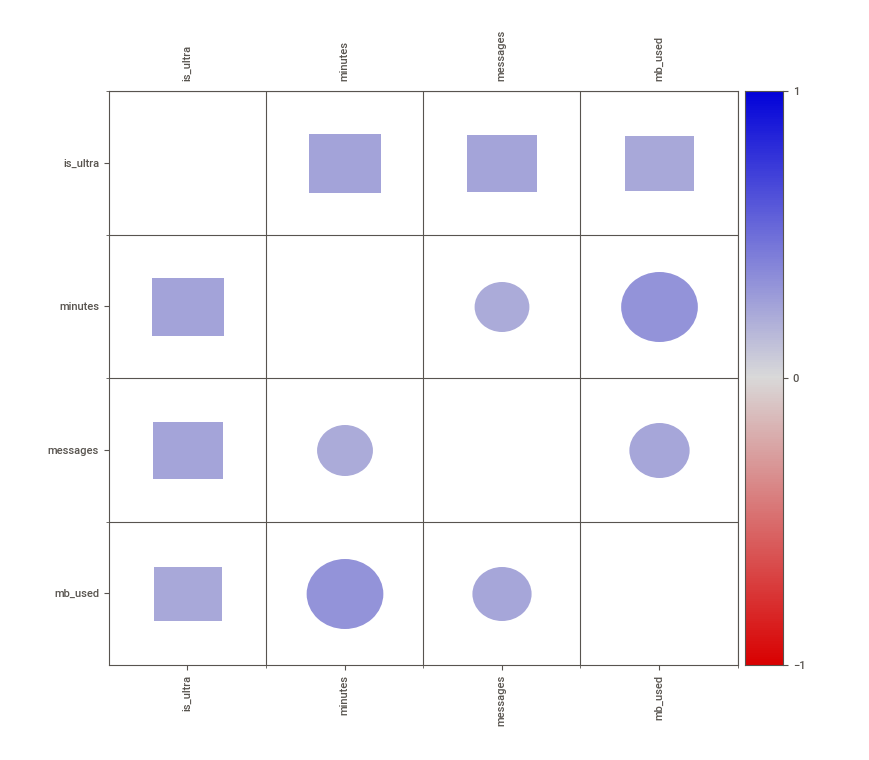
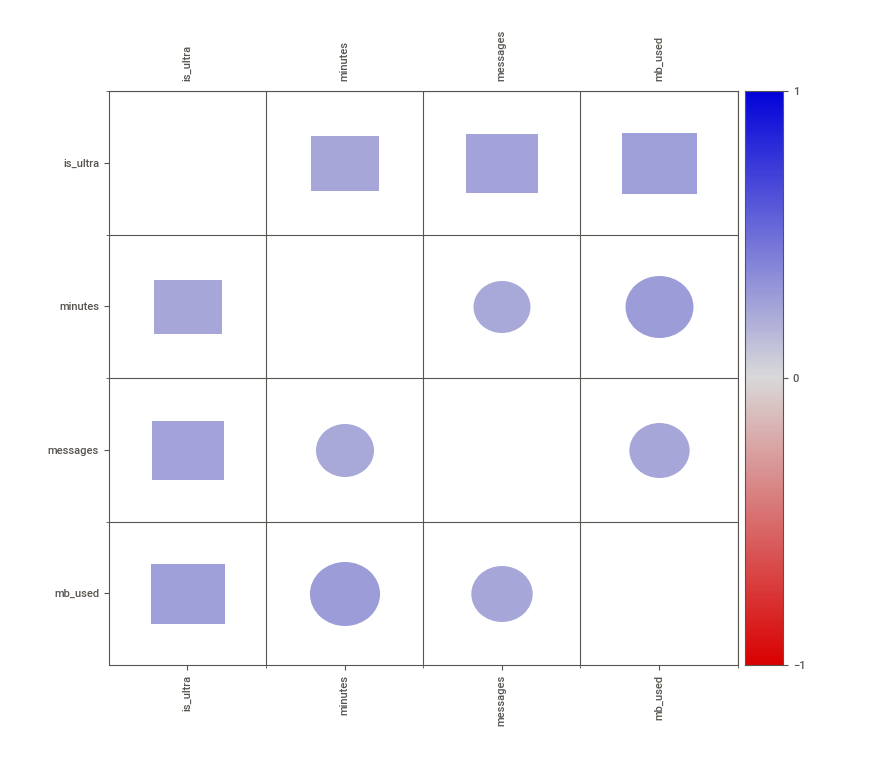

In [10]:
sv_report_2 = sv.compare([features_train, "Train"], [features_test, "Test"], target_feat='is_ultra')
sv_report_2.show_notebook() 

Из обучающего и тестового набор аданных удалим целевой признак

In [11]:
features_train = features_train.drop(['is_ultra'], axis=1)
features_test = features_test.drop(['is_ultra'], axis=1)

for name, data in {'features_train': features_train, 
                   'features_test': features_test}.items():
    print("Размер выборки %s:"  % (name),(data.shape))

Размер выборки features_train: (2571, 3)
Размер выборки features_test: (643, 3)


**Вывод**

Разделили датасет на обучающую и тестовую выборки. В тестовую выборку определяем 20% от общего набора данных, оставшиеся 80% будут использованны для обучения. Т.к. в дальнейшем планируется использование стратегии кросс-валидации, такое разбиение позволит разбить 80% обучающих данных на 4 части. На трех частях из них (60% данных) модель будет обучаться, а на оставшихся 20% проверять свое качество в процессе обучения. Такое разбиение позволит модели выявить зависимости в данных и апроксимировать решение. 

## Моделирование

### LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, GradientBoostingClassifier

Сформируем пайплайн

In [12]:
pipe = Pipeline([
    ('model', LogisticRegression(random_state=SEED))
])

params = [{
        'model': [LogisticRegression(random_state=SEED, solver='liblinear')],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.001, 1, 100],
        'model__class_weight' : [None, 'balanced']
     }, {
         'model': [DecisionTreeClassifier(random_state=SEED)],
         'model__max_depth': list(range(5, 16, 5)),
         'model__max_features': range(1, 4),
         'model__min_samples_leaf':range(5, 16, 5),
         'model__class_weight' : [None, 'balanced']
     }, {
         'model': [RandomForestClassifier(random_state=SEED)],
         'model__n_estimators': list(range(10, 201, 10)),
         'model__max_depth': list(range(5, 16)),
         'model__class_weight' : [None, 'balanced']
     }, {
         'model': [CatBoostClassifier(random_state=SEED, logging_level='Silent')]
     }, {
         'model': [GradientBoostingClassifier(random_state=SEED)]
}
]

Запустим алгоритм GridSearchCV - поиск оптимальных параметров по сетке

In [13]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=kf, verbose=False, return_train_score=True)
grid = grid.fit(features_train, target_train)
grid_pred = grid.predict(features_test)

Сгруппируем результаты GridSearchCV в таблицу

In [14]:
grid_results = pd.DataFrame(grid.cv_results_)
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'GradientBoostingClassifier']
cols = ['mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = grid_results[model_idx].sort_values(by='rank_test_score').head(1)[cols]
    res = res.append(round(best_fit, 3))
    res.loc[best_fit.index, 'model'] = model

   
res.sort_values(by='mean_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model
8,0.008,0.001,0.747,0.747,LogisticRegression
28,0.008,0.001,0.795,0.836,DecisionTreeClassifier
507,0.137,0.003,0.803,0.848,GradientBoostingClassifier
506,14.864,0.005,0.807,0.893,CatBoostClassifier
236,0.360,0.025,0.811,0.918,RandomForestClassifier


**Вывод**

Проведено моделирование с использованием следующих алгоритмов:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier 
- CatBoostClassifier 
- GradientBoostingClassifier

Лучшие показатели продемонстрировала модель Random Forest Classifier

## Проверка лучшей модели на тестовой выборке

Проверим значение метрики лучшей модели на тестовой выборке и визуализируем параметры данной модели

In [15]:
accuracy_test = round(accuracy_score(target_test, grid_pred), 3)
print('Accuracy на тестовом наборе данных:', accuracy_test)
print('Параметры лучшей модели:', grid.best_estimator_[0])

Accuracy на тестовом наборе данных: 0.809
Параметры лучшей модели: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


Проверим и другие метрики для задачи классификации

In [16]:
print(classification_report(target_test, grid_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       446
           1       0.80      0.50      0.62       197

    accuracy                           0.81       643
   macro avg       0.80      0.72      0.74       643
weighted avg       0.81      0.81      0.79       643



Визуализируем матрицу ошибок

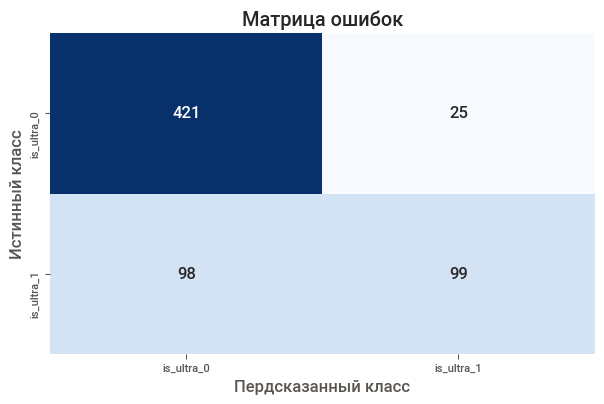

In [17]:
matrix = confusion_matrix(target_test, grid_pred)
dataframe = pd.DataFrame(matrix, index=['is_ultra_0', 'is_ultra_1'], columns=['is_ultra_0', 'is_ultra_1'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='.4g')
plt.title('Матрица ошибок');
plt.tight_layout();
plt.ylabel('Истинный класс');
plt.xlabel('Пердсказанный класс');
plt.show();

- значение в правой верхней ячейке - ошибки I рода (отрицательные примеры, неверно классифицированные как положительные)
- значение в левом нижнем углу - ошибки II рода (положительные примеры, неверно классифицированные как отрицательные)

Визуализируем какие признаки оказались самыми важными для модели

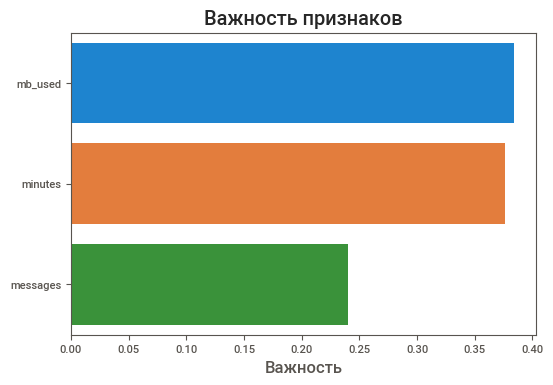

In [18]:
model_rfc = grid.best_estimator_[0].fit(features_train, target_train)
importances = pd.DataFrame(model_rfc.feature_importances_, index = features_train.columns, columns=['Важность'])
sns.barplot(data=importances, x='Важность', y=importances.index, 
            order = importances.sort_values(by='Важность', ascending = False).index)
plt.title('Важность признаков'); 

**Вывод**

Модель Random Forest Classifier на тестовой выборке продемонстрировала значение метрики accuracy 0.809  

При этом:
    - имеются ложноположительные случаи - когда вместо тарифа "Смарт" рекомендуется тариф "Ультра"
    - имеются ложноотрицательные случаи (больше, чем ложноположительных) - когда вместо тарифа "Ультра" рекомендуется тариф "Смарт"
    
Для данной задачи более критичными являются именно ложноотрицательные случаи, т.к. тариф "Ультра" более дорогой и такого рода ошибочные ситуации принесут убыток. Это также подтверждается значением метрики recall для класса 1 (тариф "Ультра"). 

Для модели наиболее важными оказались признаки "Использовано МБ" и "Суммарная длительность звонков в минутах", что объясняется современными реалиями и наличием мессенджеров у пользователей. 

## Проверка модели на адекватность

### Dummy модель

Создадим Dummy-модель для возможности проверки лучшей модели на адекватность. Метод - часто встречающееся значение.

In [19]:
# Инициализируем модель
model_dummy = DummyClassifier(random_state=SEED)
# Вызовем функции по обучению и получению предсказаний
model_dummy.fit(features_train, target_train)
predict = model_dummy.predict(features_test)
accuracy_dummy = round(accuracy_score(target_test, predict), 3)
print('Accuracy dummy-модели',accuracy_dummy)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

Accuracy dummy-модели 0.591


In [20]:
if accuracy_test <= accuracy_dummy:
    print(f'Модель с рандомными значениями показала лучший результат: {accuracy_test} <= {accuracy_dummy}')
else:
    print(f'Модель случайного леса показала лучший результат: {accuracy_test} > {accuracy_dummy}')

Модель случайного леса показала лучший результат: 0.809 > 0.591


## Общий вывод

Проанализирован набор данных оператора сотовой связи. Перед исследованием стояла задача построения классификационной модели по рекомендации одного из двух тарифов (бинарная классификация).

В качестве метрики было обозначено Accuracy, что не совсем корректно для данных, в которых имеется дисбаланс. Т.к. метрика может показывать большие значения, только лишь потому, что она правильно угадывает тот класс, которого количественно больше (мажоритарный класс). 

Т.к. процесс предобработки данных был проведен на предыдущем этапе - не было необходимости в обработке данных. Была проведена работа только по устранению мультиколлинеарности (из данных был удален один из коррелирующих признаков - calls, т.к. тариф в большей степени характеризуется количеством использованных минут, нежели количеством звонков.)

Набор данных был разбит на обучающую и тестовую выборки. На обучающей выборке алгоритмы обучались выявлять зависимости в данных. В алгоритме по подбору гиперпараметров использовалась стратегия кросс-валидации, которая позволяет минимизировать проблему переобучения алгоритма. На отложенной тестовой выборке проверялась работа алгоритма, который, в сравнении с другими, показал лучшие результаты в процессе обучения. 

В процессе моделирования были использованы следующие алгоритмы:

LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
CatBoostClassifier
GradientBoostingClassifier

Для алгоритмов задавались диапазоны гиперпараметров для нахождения их оптимальных значений. Среди прочих указывался параметр `class_weight`, который позволяет учесть дисбаланс классов.

Лучшие показатели продемонстрировала модель Random Forest Classifier.

Победившая модель на отложенной выборке продемонстрировала  значение 0.809, что больше чем требуемый baseline (0.75). 
Также модель была проверена на адекватность - проведено сравнение с dummy-моделью, которая генерирует случайные классы по стратегии часто встречающегося значения. Dummy-модель продемонстрировала метрику 0.59, что значительно ниже метрики проверяемой модели. 

Несмотря на хорошие показатели требуемой метрики, есть задел для улучшения модели, т.к. дополнительный анализ показал:

- наличие ложноположительных случаев - когда вместо тарифа "Смарт" рекомендуется тариф "Ультра"
- наличие ложноотрицательных случаев - когда вместо тарифа "Ультра" рекомендуется тариф "Смарт"

Для данной задачи более критичными являются именно ложноотрицательные случаи, т.к. тариф "Ультра" более дорогой и такого рода ошибочные ситуации принесут убыток. Это также подтверждается значением метрики recall для класса 1 (тариф "Ультра").

Для получившейся модели наиболее важными оказались признаки "Использовано МБ" и "Суммарная длительность звонков в минутах", что объясняется современными реалиями и наличием мессенджеров у пользователей.

В ходе анализа также выло выявлено, что рекомендательную систему можно построить даже без использования модели машинного обучения, а ориентируясь только на некие экспертные правила (пороги по значениям признаков), по которым можно определить в какой момент ползователю можно предлагать более выгодный тариф (как для самого пользователя - по предлагаемому пакету услуг, так и для сотового оператора - по стоимости абонентской платы). В качестве примера, можно выбрать следующие пороги: 400 минут, 18 ГБ, 100 сообщений.